## Downloading The Dataset

In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"navinbondade23","key":"282f290157256acc09141ba03f1ccae2"}'}

In [4]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d snap/amazon-fine-food-reviews

 97% 236M/242M [00:01<00:00, 143MB/s]
100% 242M/242M [00:01<00:00, 153MB/s]


In [9]:
from zipfile import ZipFile
file_name = '/content/amazon-fine-food-reviews.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Installing BERTopic & Contractions

In [37]:
!pip -q install bertopic

In [58]:
!pip -q install contractions

     |████████████████████████████████| 284 kB 5.3 MB/s 
     |████████████████████████████████| 321 kB 35.4 MB/s 


## Importing Libraries

In [2]:
from bertopic import BERTopic

import pandas as pd
import numpy as np
import re
import contractions
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
plt.style.use('ggplot')

## Importing Data

In [7]:
review_data= pd.read_csv("/content/Reviews.csv")
review_data.dropna(axis = 0, how ='any',inplace=True) 
review_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
print('Shape of dataset:')
print(review_data.shape)

Shape of dataset:
(568411, 11)


## Sampling Data

In [15]:
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 
max_review_sentence_length  = review_data['Num_words_text'].max()
m = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[m]
df_sampled_data = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=15000)).reset_index(drop = True)

In [16]:
print('Shape of dataset:')
print(df_sampled_data.shape)

Shape of dataset:
(75000, 11)


## Cleaning The Data

In [21]:
def remove_accented(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return x

In [22]:
def get_clean(X):
    X = str(X).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ').replace(':', '')
    X = contractions.fix(X)
    X = X.replace('#', "")
    X = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"",  X)
    X = re.sub(r'[^\w\d\s]+','', X)
    X = ' '.join(X.split())
    X = BeautifulSoup(X, 'lxml').get_text().strip()
    X = remove_accented(X)
    X = re.sub(r'[^\w ]+','',X)
    X = re.sub("(.)\\1{2,}", "\\1", X)
    X = ' '.join([word for word  in X.split() if word not in  stopwords])
    return X

In [23]:
df_sampled_data['Text'] = df_sampled_data['Text'].apply(lambda x: get_clean(x)) 

## Word Cloud

In [19]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['figure.dpi'] = 80

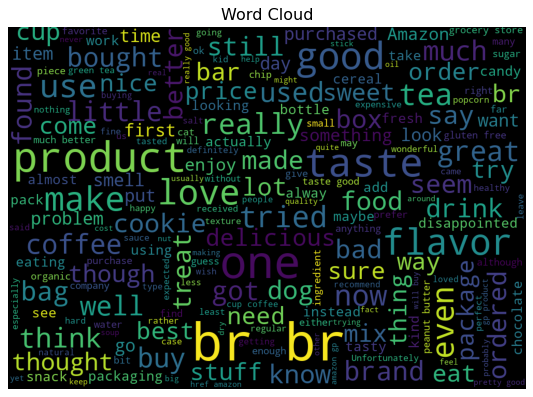

In [20]:
word_cloud = WordCloud(width=1000, height=700, max_font_size=100).generate(' '.join(df_sampled_data['Text']))
plt.imshow(word_cloud)
plt.title('Word Cloud')
plt.axis('off')
plt.show()

##Traning The Model

In [29]:
topic_model = BERTopic(verbose=True, embedding_model="paraphrase-MiniLM-L12-v2", min_topic_size=50,  calculate_probabilities=True)

In [30]:
topic_model.get_params()

{'calculate_probabilities': True,
 'diversity': None,
 'embedding_model': 'paraphrase-MiniLM-L12-v2',
 'hdbscan_model': HDBSCAN(min_cluster_size=50, prediction_data=True),
 'language': None,
 'low_memory': False,
 'min_topic_size': 50,
 'n_gram_range': (1, 1),
 'nr_topics': None,
 'seed_topic_list': None,
 'top_n_words': 10,
 'umap_model': UMAP(low_memory=False, metric='cosine', min_dist=0.0, n_components=5),
 'vectorizer_model': CountVectorizer(),
 'verbose': True}

In [33]:
data = list(df_sampled_data['Text'])
topics, probs = topic_model.fit_transform(data)

Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

2022-01-25 08:26:20,073 - BERTopic - Transformed documents to Embeddings
2022-01-25 08:28:22,953 - BERTopic - Reduced dimensionality with UMAP
2022-01-25 08:29:21,212 - BERTopic - Clustered UMAP embeddings with HDBSCAN


## Getting Topic Frequency

In [36]:
freq = topic_model.get_topic_info()

In [37]:
freq.head(5)

,Topic,Count,Name
0,-1,27580,-1_br_like_taste_coffee
1,0,5679,0_dog_dogs_treats_food
2,1,5066,1_tea_teas_green_chai
3,2,3481,2_coffee_roast_starbucks_cup
4,3,2646,3_amazon_date_price_product


## The most frequent Topic

In [38]:
topic_model.get_topic(0) 

[('dog', 0.05156379468141424),
 ('dogs', 0.03996429675754472),
 ('treats', 0.02765926081205269),
 ('food', 0.020372989824416557),
 ('treat', 0.018460647490797927),
 ('loves', 0.0159897402203794),
 ('toy', 0.013962980138387891),
 ('puppy', 0.012470979433657147),
 ('chew', 0.011402000413166283),
 ('bones', 0.009671260096055878)]

## Data Visualization

## Visualize The Topics

In [39]:
topic_model.visualize_topics()

## Barchart

In [40]:
topic_model.visualize_barchart()

## Heatmap

In [41]:
topic_model.visualize_heatmap()